In [1]:
import os
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers.convolutional import UpSampling2D, Conv2D
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print('tensorflow', tf.__version__)

tensorflow 2.6.0


In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
print('Max pixel:', train_x.max())
print('Min pixel:', train_x.min())

Max pixel: 255
Min pixel: 0


In [4]:
# 이미지를 [-1, 1] 로 정규화하기 위한 작업
train_x = (train_x - 127.5) / 127.5

print('Max pixel:', train_x.max())
print('Min pixel:', train_x.min())

Max pixel: 1.0
Min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

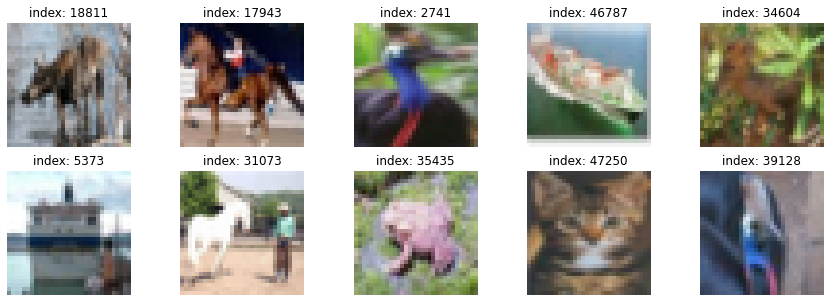

In [6]:
plt.figure(figsize=(15, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index] + 1)/2)
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [7]:
def make_generator_model_one():

  model = tf.keras.Sequential()

  model.add(layers.Dense(8 * 8 * 128, activation='relu', input_shape=(100,)))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  model.add(layers.Reshape((8, 8, 128)))

  model.add(layers.Conv2D(128, kernel_size=4, strides=1, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  model.add(layers.Conv2D(128, kernel_size=5, strides=1,padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  model.add(layers.Conv2D(3, kernel_size=5, strides=1, padding="same", activation='tanh'))

  return model

In [8]:
generator_one = make_generator_model_one()

generator_one.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              827392    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 128)         262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [9]:

# 노이즈를 생성합니다.
noise = tf.random.normal([1, 100])
generated_image = generator_one(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

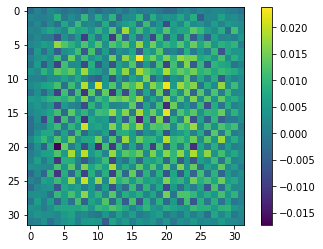

In [10]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [11]:
def make_discriminator_model_one():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=(32, 32, 3), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [12]:
discriminator_one = make_discriminator_model_one()

discriminator_one.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)         

In [13]:
decision = discriminator_one(generated_image, training=False)

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [20]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [22]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator_one(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator_one(images, training=True)
        fake_output = discriminator_one(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_one.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_one.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_one.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_one.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [23]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(np.array(predictions[i] * 127.5 + 127.5).astype('uint8'))
        plt.axis('off')

    save_dir = '/aiffel/dcgan_newimage/fashion/'
    os.makedirs(save_dir, exist_ok=True)

    # Save the images
    plt.savefig(os.path.join(save_dir, 'generated_samples_{:04d}_iter_{:03d}.png'.format(epoch, it)))
    plt.show()

In [24]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 # matlab 차트의 기본 크기를 15, 6 으로 지정

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.xlabel('batch iters')
    plt.ylabel('accuracy')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    # training_history 디렉토리에 epoch 별로 그래프를 이미지 파일로 저장
    plt.savefig('/aiffel/dcgan_newimage/fashion/traing_history_{:04d}.png'.format(epoch))

    plt.show()

In [25]:
checkpoint_dir = '/aiffel/dcgan_newimage/fashion/training_chekpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_one,
                                 discriminator=discriminator_one)

In [26]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_one, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator_one, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [27]:
save_every = 5
EPOCHS = 300

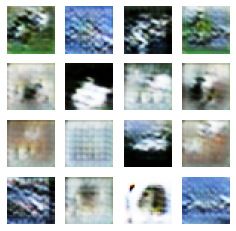

Time for training : 4405 sec


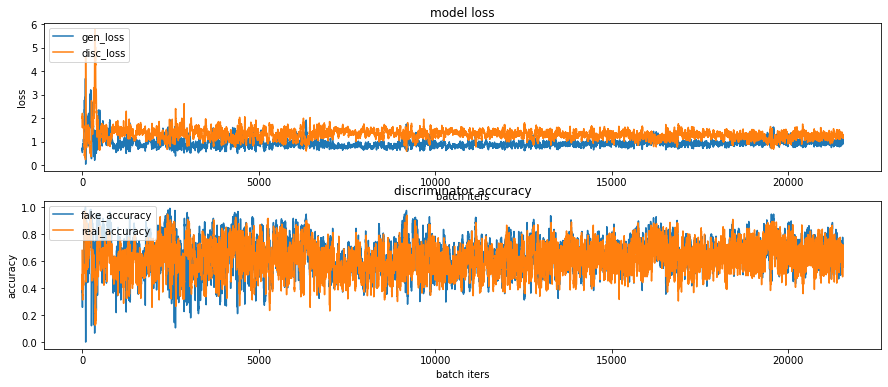

In [ ]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)